# ACS2 in Maze Experiments
The following notebooks provides reproducible playground for experimenting how ACS2 agent behaves inside Maze environments.
## Imports and configuration
Load project files from upper directory (nasty solution).

In [36]:
import sys
sys.path.append('/Users/khozzy/Projects/pyalcs')

Import `pyalcs` module

In [37]:
# Enable automatic module reload
%load_ext autoreload
%autoreload 2

from alcs.agent.acs2 import ACS2
from alcs.environment.maze import Maze

# Metrics
from alcs.helpers.metrics import \
    ActualStep,\
    ClassifierPopulationSize,\
    AveragedFitnessScore,\
    SuccessfulTrial,\
    AveragedConditionSpecificity,\
    AchievedKnowledge

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Other helpers

In [38]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd

## Experiment
We are going to test ACS2 **agent** inside **maze** environment. The agent will have 2 tasks:
1. learn the shortest path to the goal state,
2. learn the internal model of the environment

### Maze
Currently there are 4 mazes implemented:
- `mazes/MazeF1.maze` (deterministic),
- `mazes/MazeF2.maze` (deterministic),
- `mazes/MazeF3.maze` (deterministic),
- `mazes/MazeF4.maze` (non-deterministic)

Maze `MazeF4` introduces also the *aliasing* problem - the are two states that looks exactly the same for an agent.

In [39]:
# Location of the maze file
MAZE_LOCATION = 'mazes/MazeF2.maze'

And visualize it

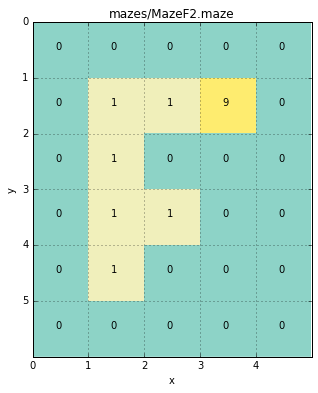

In [40]:
env = Maze(MAZE_LOCATION)

fig = plt.figure(figsize=(env.max_x, env.max_y))
ax = fig.add_subplot(111, aspect='equal')

# Render maze as image
plt.imshow(env.matrix, interpolation='none', cmap='Set3', aspect='auto',
           extent=[0, env.max_x, env.max_y, 0])

# Add labels to each cell
for x in range(0, env.max_x):
    for y in range(0, env.max_y):
        plt.text(x+0.4, y+0.5, env.matrix[y][x])

ax.set_title(MAZE_LOCATION)
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.xlim(0, env.max_x)
plt.ylim(env.max_y, 0)

plt.xticks(range(0, env.max_x))
plt.yticks(range(0, env.max_y))

plt.grid(True)
plt.show()

**Legend / reward map**:
- `0` is a $wall$ (cannot cross),
- `1` is a $path$ (reward $\rho = 0$),
- `9` is a $price$ (reward $\rho = 1000$)

### Agent
Agent moves in maze for the certain number of steps.

> **Trial** is a successful run of agent when he manages to find the reward.

> After learning it should take him less and less steps to reach the goal.

At the beginning of each trial an agent is randomly placed inside the maze. He can perceive 4 values (neighbourhood cells - N, E, S, W) and move in 4 directions (N, E, S, W).

In [41]:
agent = ACS2()

### Run the simulation
The whole simulation will run a certain number of times for certain number of steps.

In [42]:
# Number of experiments
EXPERIMENTS = 20

# Number of agent steps for each experiment
STEPS = 2000 # 10 000

We are also going to capture some metrics. Let's add handler for the agent.

In [43]:
agent.add_metrics_handlers([
        ActualStep('time'),
        SuccessfulTrial('found_reward'),
        ClassifierPopulationSize('total_classifiers'),
        AveragedFitnessScore('average_fitness'),
        AveragedConditionSpecificity('average_specificity'),
        AchievedKnowledge('achieved_knowledge')
    ])

After all the object `performance` will hold performance metrics useful for visualization.

In [44]:
performance = pd.DataFrame()

for experiment in range(EXPERIMENTS):
    
    # Re-initialize the environment
    env = Maze(MAZE_LOCATION)
    
    # Evaluate algorithm
    classifiers, metrics = agent.evaluate(env, STEPS)
    
    # Add information about the experiment into metrics
    metrics['experiment_id'] = [experiment] * len(metrics['time'])
    
    # Append performance metrics
    performance = performance.append(pd.DataFrame(metrics))

We can also inspect how the classifier population looks. Internal model of the environment is specified only by reliable classifiers.

In [45]:
reliable = [c for c in classifiers if c.q > 0.9]

print("Population classifiers: {}".format(len(classifiers)))
print("Reliable classifiers: {}\n".format(len(reliable)))

for cls in reliable:
    print(cls)

Population classifiers: 103
Reliable classifiers: 28

Classifier{0100-0-1011 q:1.00, r:3036.75}
Classifier{10##-0-#### q:1.00, r:2007.65}
Classifier{##1#-0-#### q:1.00, r:1978.16}
Classifier{##11-0-#### q:1.00, r:2154.53}
Classifier{#01#-0-#### q:1.00, r:1978.16}
Classifier{###1-0-#### q:1.00, r:2154.53}
Classifier{#0##-0-#### q:1.00, r:1877.27}
Classifier{0##1-3-1##0 q:1.00, r:1145.53}
Classifier{#109-0-#011 q:1.00, r:3887.19}
Classifier{1##0-2-#### q:1.00, r:2216.08}
Classifier{###9-1-#### q:1.00, r:2356.52}
Classifier{###0-2-#### q:0.99, r:2673.52}
Classifier{##00-2-#### q:0.91, r:2688.84}
Classifier{1011-2-0100 q:1.00, r:3101.89}
Classifier{1#0#-2-#### q:1.00, r:1456.60}
Classifier{##09-3-#### q:0.97, r:3018.63}
Classifier{###9-3-#### q:0.99, r:3018.63}
Classifier{###9-2-###0 q:1.00, r:8216.56}
Classifier{#109-2-###0 q:1.00, r:8216.56}
Classifier{1010-2-#### q:1.00, r:2316.50}
Classifier{0100-2-#### q:1.00, r:3093.46}
Classifier{#100-2-#### q:1.00, r:3093.46}
Classifier{1000-2-####

<p style="color:red">**TODO**: There are duplicate classifiers!!!! Maybe subsumption does not works. Why low quality classifiers are not removed?</p>

## Performance metrics
Let's have a look how the performance metrics look like by taking 5 random samples:

In [46]:
performance.sample(5)

,achieved_knowledge,average_fitness,average_specificity,experiment_id,found_reward,time,total_classifiers
592,0.545455,0.000000,0.418421,2,False,593,95
445,0.545455,0.000000,0.426724,6,False,446,116
298,0.454545,0.000000,0.416667,9,False,299,54
1750,0.818182,226.958084,0.632114,12,False,1751,123
1030,0.545455,140.670530,0.467290,0,False,1031,107


### Number of steps to food
Measures if the classifier actually *learns* something along the time.

> **Number of steps to food** - How many steps were needed in **each trial** to found the reward.

We need to have a little helper function for operating on obtained measurements.

In [47]:
def get_avg_number_of_steps_to_food(performance):
    trials_by_experiment = pd.DataFrame(performance
                                        .groupby('experiment_id')
                                        .apply(lambda x: x['found_reward'].cumsum())
                                        .stack())
    trials_by_experiment.reset_index(inplace=True)
    trials_by_experiment.rename(columns = {'found_reward': 'time', 0: 'trial'},
                                inplace=True)

    # Experiment_id, trial, steps
    steps_per_trial_in_experiment = pd.DataFrame(trials_by_experiment
                                                 .groupby(['experiment_id', 'trial'])
                                                 .size())
    steps_per_trial_in_experiment.reset_index(inplace=True)
    steps_per_trial_in_experiment.rename(columns = {0: 'steps'}, inplace=True)

    # Trial, averaged steps
    averaged_steps_per_trial = pd.DataFrame(steps_per_trial_in_experiment.groupby('trial')['steps'].mean())
    averaged_steps_per_trial.rename(columns = {'steps': 'averaged_steps'}, inplace=True)
    averaged_steps_per_trial.reset_index(inplace=True)
    
    return averaged_steps_per_trial

Now we can visualize the results

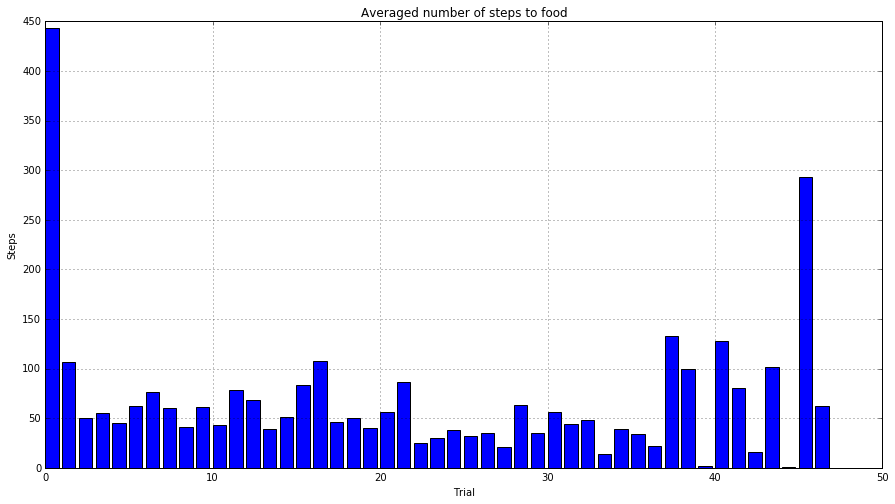

In [48]:
steps_to_food = get_avg_number_of_steps_to_food(performance)

fig = plt.figure(figsize=(15, 8), dpi=100)

plt.bar(steps_to_food['trial'], steps_to_food['averaged_steps'])
plt.title('Averaged number of steps to food')
plt.xlabel('Trial')
plt.ylabel('Steps')

# plt.yscale('log')
plt.grid(True)

plt.show()

### Achieved knowledge
Measures if an agent is *learning* the environment.

> **Achieved knowledge** - test whether or not there is a **reliable classifier** for each transition $(\sigma_{1}, \alpha, \sigma_{2})$ with $\sigma_{1} \neq \sigma_{2}$ that can be applied in $\sigma_{1}$ and anticipates $\sigma_{2}$ correctly.

This metric is calculated after each time-step done by the agent.

In [49]:
def get_avg_achieved_knowledge_per_step(performance):
    knowledge_per_step = pd.DataFrame(performance.groupby('time')['achieved_knowledge'].mean())
    knowledge_per_step.reset_index(inplace=True)
    return knowledge_per_step

Plot the results

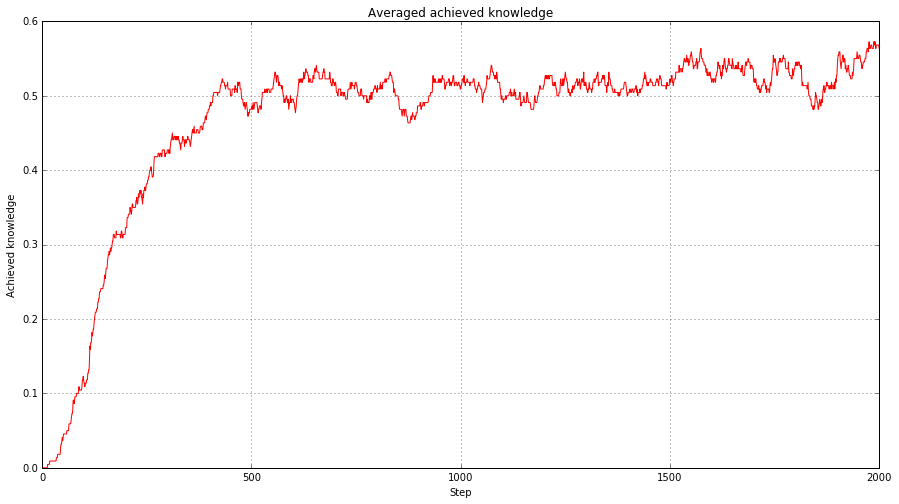

In [50]:
knowledge_per_step = get_avg_achieved_knowledge_per_step(performance)

fig = plt.figure(figsize=(15, 8), dpi=100)

plt.plot(knowledge_per_step['time'], knowledge_per_step['achieved_knowledge'], 'r')
plt.title('Averaged achieved knowledge')
plt.xlabel('Step')
plt.ylabel('Achieved knowledge')

plt.grid(True)

plt.show()

### Specificity measure
Measure the *generalization* in classifier population.

> **Specificity measure** - Equal to the **sum** of all specialized attributed in condition part of all classifiers in population **divided** by the number of classifiers **times** the length of  the perception $\sigma$.

You can read more about this metric in "*Introducing a Genetic Generalization Pressure to the
Anticipatory Classfierier System - Part2: Performance Analysis*" by Martin V. Butz.

Plot should change after modifing the agent's *mutation* and *cross over* values. The author claims that the best generalization was reached for mutation rate $\mu = 0.4$.

In [51]:
def get_avg_specificity_per_step(performance):
    spec_per_step = pd.DataFrame(performance.groupby('time')['average_specificity'].mean())
    spec_per_step.reset_index(inplace=True)
    return spec_per_step

Plot the results

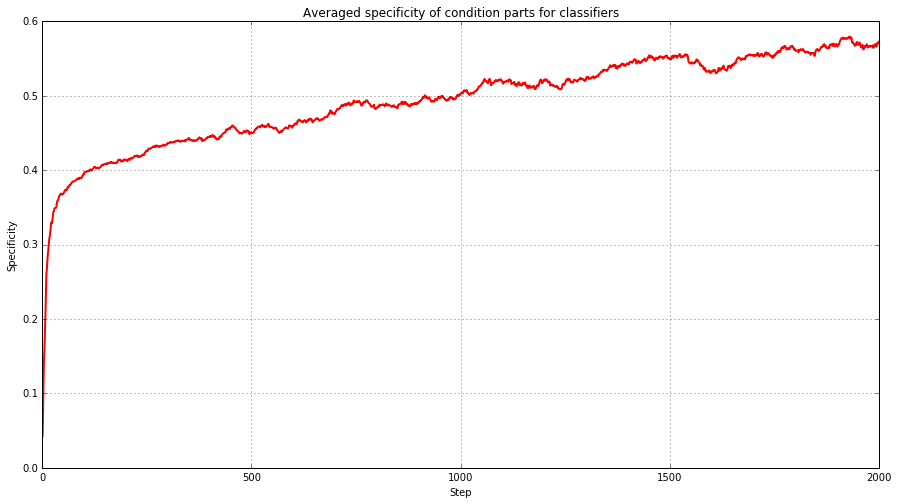

In [52]:
spec_per_step = get_avg_specificity_per_step(performance)

fig = plt.figure(figsize=(15, 8), dpi=100)

plt.plot(spec_per_step['time'], spec_per_step['average_specificity'], 'r', linewidth=2)
plt.title('Averaged specificity of condition parts for classifiers')
plt.xlabel('Step')
plt.ylabel('Specificity')

plt.grid(True)

plt.show()

We can observe that the value stabilizes near 0.45 which means most elements of condition part is wildcards.

We can execute another experiment, but this time also the mutation ratio will change.

The following image presents how the alternative plot can look like:
![title](temp/generalization.png)